<a href="https://colab.research.google.com/github/s1m0n32001/PercolationML/blob/main/DirectedPercolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning of Directed Percolation

## Physics of Complex Systems, Final Project

### Student: Simone Toso (2095484)

The goal of this project is to implement the method described in the paper *Supervised and unsupervised learning of directed percolation* (Shen et. al).


#### TO DO LIST:
 - Unsupervised: train an autoencoder with one hidden neuron on the whole dataset. Plot value of hidden neuron
 - Teoria, markdown

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0. A bit of theory

The term *bond directed percolation* refers to a stochastic process which reminds us of a drop of water which, under the effect of gravity, flows downwards through a porous medium.

The process takes place on a lattice whose nodes $i$ can be either wet ($1$) or dry ($0$). If at time $t$ the node $i$ is wet, at time $t+1$ it can wet one of its adjacent nodes with probability $p$. This term (known as *bond probability*) represents the probability for a node to connect with one of its adjacent nodes.

The system has only one absorbing state, which intuitively corresponds to the situation in which all nodes are dry.
The value of $p$ plays a crucial role in determining whether the system will reach the absorbing state or not. Numerical estimates found a critical value of $p_c \approx 0.645$ for the DP model in $1+1$ dimension. For $p<p_c$, clusters generated by a single active node will eventually die after a finite timespan. For $p > p_c$, there is a finite probability for a cluster to extend up to infinity. At $p = p_c$, clusters of all sizes appear.



### 1. Bond DP simulation
We start by simulating a bond DP process, reproducing fig.1 from the paper. Although not strictly necessary for the project task, this is useful to visualize what is going on and to check that the DP process is correctly simulated.

In [3]:
import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from scipy.stats import linregress as linear_fit
from scipy.optimize import curve_fit

torch.manual_seed(1235)
np.random.seed(1235)

# Use GPU if runtime allows it, otherwise use CPU
device = None
if torch.cuda.is_available():
  device = torch.device("cuda") #to use gpu
else:
  device = torch.device("cpu")

In [4]:
print("GPUs available:", torch.cuda.is_available())

GPUs available: True


In [5]:
"""
Function to simulate bond DP in (1+1) dimension.
 L: lattice size
 T: timesteps to simulate
 p: bond probability
 z_minus: tensor of shape (T,L) with values in [0,1], bond probability between site i and i-1
 z_plus: same thing, for site i and i+1
 full: if True, initiate all sites as active. If False, only site L//2 is initiated as active
"""

def simulate_DP(L: int, T:int, p: float,
                device : torch.device = torch.device("cpu"),
                full: bool = False) -> torch.Tensor:
  config = torch.zeros((T, L)).to(device)
  z_minus, z_plus = torch.rand((T,L)).to(device), torch.rand((T,L)).to(device)

  # Initialize configuration
  if full:
    config[0, :] = 1
  else:
    config[0, L//2] = 1

  # Compute active and inactive sites
  for t in range(1, T):
    mask_left = torch.roll(config[t-1, :], shifts = -1)
    mask_left[-1] = 0                                   # border condition
    mask_right = torch.roll(config[t-1, :], shifts = 1)
    mask_right[0] = 0                                   # border condition
    config[t, :] = torch.bitwise_or(torch.bitwise_and(mask_left > 0, z_minus[t, :] < p),
                                    torch.bitwise_and(mask_right > 0, z_plus[t, :] < p))
  return config


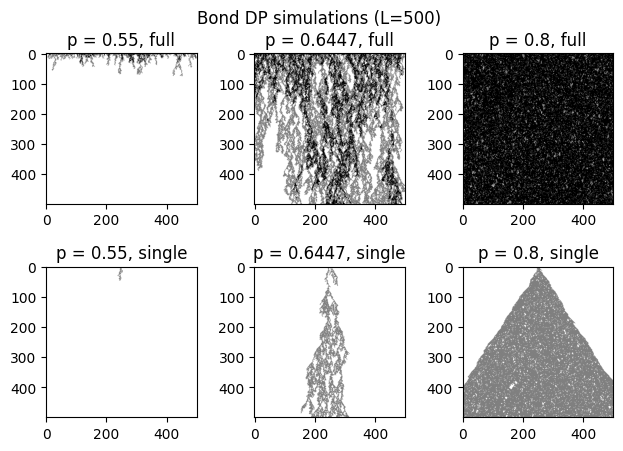

In [6]:
# Plot DP simulations for different values of p
L, T = 500, 500
ps = [0.55, 0.6447, 0.8]

fig, ax = plt.subplots(2, 3)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Bond DP simulations (L=500)")

for i, full in enumerate([True, False]):
  for j, p in enumerate(ps):
    config = simulate_DP(L, T, p, device = device, full = full).cpu()
    ax[i,j].imshow(1-config, cmap = 'gray')
    ax[i,j].set_title(f'p = {p}, ' + ('full' if full else 'single'))

In [7]:
Ls = [8, 16, 32, 48, 64] # used system sizes
p_min, p_max = .4, .9
p_critical = .6447

ps = np.linspace(p_min, p_max, 40) # used probabilities
n_samples = 2500 # number of samples per probability value

## Data generation - run first time only!

We follow the method described in the paper and generate the data according to the following procedure:
 - We simulate bond DP processes in 1(+1) dimension, with lattice length $L = 8, 16, 32, 48, 64$.
 - For each length, the bond probability $p$ is set to 40 values between $0.4$ and $0.9$.
 - For each value of the parameters $(p,L)$, we simulate 2500 processes.

 Only run this cell the first time that you work with this code. It will save the dataset on your Google Drive in a .pckl format, so that you don't have to generate the dataset every time.


In [ ]:
"""
Generate 2500 configurations for each value of p and each value of L
      and save the corresponding label
"""

configurations = []

for L in Ls:
  dataL = torch.zeros((n_samples*len(ps), L, L)).to(device) # shape has to be *len(ps)
  for i,p in enumerate(ps):
    for j in range(n_samples):
      dataL[i*n_samples + j, :, :] = simulate_DP(L, L, p, device, full = True)

  print("Finished simulating with L = ", L, "\n")
  configurations.append(dataL)


NameError: name 'Ls' is not defined

In [ ]:
#Save data in google drive
for i,L in enumerate(Ls):
  file_name = "/content/drive/MyDrive/datasetL" + str(L)
  torch.save(configurations[i], file_name)

## Data loading and label preparation

We load the data and prepare the `torch.Dataset` objects. We split into training, validation and test with a 5:2:2 ratio.

In [8]:
# Load data from .pckl files generated during the creation of the dataset
configurations = []

for L in Ls:
  configurations.append(torch.load("/content/drive/MyDrive/datasetL" + str(L),
                                   map_location=torch.device(device)))

# Prepare the labels --> 2500 * 0 if p < ... else 2500 * 1
datalabels = []

for i,p in enumerate(ps):
  lista = n_samples*[0] if p < p_critical else n_samples*[1]
  datalabels = datalabels + lista

datalabels = torch.tensor(datalabels).unsqueeze(1).to(device).type(torch.float32)
ps_dataset = []

for p in ps:
  ps_dataset = ps_dataset + n_samples * [p]

ps_dataset = np.array(ps_dataset)

## FCN and CNN training

We train two shallow neural networks to predict whether the lattice comes from a simulation of $p$ lower or greater than $p_c$.

The network architectures are the following:

**FCN** (same as in the paper):
 - Input layer of $L \times L$ neurons
 - Hidden layer of 128 neurons
 - Output layer of 2 neurons

**CNN**:
 - Convolutional layer: 16 channels, kernel size 3
 - Maxpooling layer, kernel size 2, stride 2
 - Fully Connected layer

In [9]:
""" Fully Connected Network for binary classification
 - Input layer of LxL neurons
 - 128 hidden neurons
 - 2 output neurons
"""
class FCN(nn.Module):
  def __init__(self, L):
    super(FCN, self).__init__()
    self.name = "FCN"
    self.input_layer = nn.Linear(L*L, 128)
    self.hidden_layer = nn.Linear(128, 1)

  def forward(self, data):
    data_flat = torch.flatten(data, start_dim = 1, end_dim = -1)
    data_flat = self.input_layer(data_flat)
    out = self.hidden_layer(data_flat)
    return out



""" Convolutional Neural Network for binary classification
 - Convolutional layer with kernel of size 2x2, 16 channels
 - Maxpool layer
 - Fully connected layer for binary classfication
"""
class CNN(nn.Module):
  def __init__(self, L):
    super(CNN, self).__init__()
    self.name = "CNN"
    #Input shape: 1 x L x L
    self.out_channels = 16
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = self.out_channels,
                           kernel_size = 3, padding = 'same', padding_mode = 'zeros')
    #Pooling layer to half size
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    n_neurons = L*L//4*self.out_channels
    self.fcl = nn.Linear(n_neurons, 1)

  def forward(self, x):
    x_conv = self.conv1(x)
    x_conv = self.pool1(x_conv)
    x_flat = torch.flatten(x_conv, start_dim = 1, end_dim = -1) #flatten
    return self.fcl(x_flat)


In [10]:
def train_models(Ls: list, model = FCN):
  percolation_probabilities = {}
  for i,L in enumerate(Ls):

    """
      Prepare the dataset with lattice size L
      Shuffle and split in training, validation and test with a 5:2:2 ratio
    """
    dataset = torch.utils.data.TensorDataset(configurations[i],
                                            datalabels)
    permutation = npr.permutation(len(dataset))
    dataset = torch.utils.data.Subset(dataset, permutation)
    ps_ordered = ps_dataset[permutation]

    dataset_size = len(dataset)
    train_ratio = 5./9.
    val_ratio = 2./9.
    test_ratio = 2./9.

    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
    val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
    test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))

    ps_test = ps_ordered[-test_size:]

    """
      Initialize the shallow FCN and train it on the data.
      Given the simple network, few epochs should be sufficient
    """
    network = model(L = L) # FCN
    criterion = nn.BCEWithLogitsLoss() # BCE + sigmoid
    optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.01)  # L2 regularization term (weight decay)
    num_epochs = 5
    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    network.to(device)

    print("-------------------------------\n\n\n")
    print("Training", network.name ,"with L = ", L, "\n")

    for epoch in range(num_epochs):
      network.train()
      train_loss = 0.0
      for inputs, labels in train_loader:
        if network.name == "CNN":
                inputs = torch.unsqueeze(inputs, 1)
        optimizer.zero_grad()
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
      train_loss /= len(train_loader.dataset)

      network.eval()
      val_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          for inputs, labels in val_loader:
              if network.name == "CNN":
                inputs = torch.unsqueeze(inputs, 1)
              outputs = network(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * inputs.size(0)

              predicted = torch.round(torch.sigmoid(outputs))
              correct += (predicted == labels).sum().item()
              total += labels.size(0)

      val_loss /= len(val_loader.dataset)
      val_accuracy = correct / total
      print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.2%}')


    """ Compute percolation probability for each test set"""

    pprobL = {}
    countL = {}
    network.eval()
    with torch.no_grad():
      for index, (data, labels) in enumerate(test_loader):
        if network.name == "CNN":
                data = torch.unsqueeze(data, 1)
        output = torch.round(torch.sigmoid(network(data)))
        if ps_test[index] in pprobL.keys() and output == 1:
          pprobL[ps_test[index]] += 1
          countL[ps_test[index]] += 1
        elif ps_test[index] in pprobL.keys():
          countL[ps_test[index]] += 1
        else:
          pprobL[ps_test[index]] = 1
          countL[ps_test[index]] = 1

    for key in pprobL.keys():
      pprobL[key] /= countL[key]

    percolation_probabilities[str(L)] = pprobL
  return percolation_probabilities




In [11]:
percolation_probabilities_FCN = train_models(Ls, FCN)
percolation_probabilities_CNN = train_models(Ls, CNN)

-------------------------------



Training FCN with L =  8 

Epoch [1/5], Training Loss: 0.2802, Validation Loss: 0.2541, Validation Accuracy: 89.34%
Epoch [2/5], Training Loss: 0.2669, Validation Loss: 0.2720, Validation Accuracy: 88.79%
Epoch [3/5], Training Loss: 0.2651, Validation Loss: 0.2562, Validation Accuracy: 89.08%
Epoch [4/5], Training Loss: 0.2648, Validation Loss: 0.2565, Validation Accuracy: 89.12%
Epoch [5/5], Training Loss: 0.2640, Validation Loss: 0.2525, Validation Accuracy: 89.34%
-------------------------------



Training FCN with L =  16 

Epoch [1/5], Training Loss: 0.1631, Validation Loss: 0.1963, Validation Accuracy: 91.94%
Epoch [2/5], Training Loss: 0.1526, Validation Loss: 0.1884, Validation Accuracy: 92.11%
Epoch [3/5], Training Loss: 0.1511, Validation Loss: 0.1486, Validation Accuracy: 93.81%
Epoch [4/5], Training Loss: 0.1492, Validation Loss: 0.1421, Validation Accuracy: 93.79%
Epoch [5/5], Training Loss: 0.1469, Validation Loss: 0.1399, Validation Ac

## Plot graphs

In [12]:
def plot_figure(Ls: list, percolation_probabilities: dict, modeltype : str = "FCN"):
  fig, ax = plt.subplots(1, 3, figsize = (14, 3))

  """
    Recreate first panel of fig. 4 of the paper
    Show p_critical from theory as a vertical line
  """

  cmap = plt.get_cmap('coolwarm')
  colors = cmap(np.linspace(0, 1, len(Ls)))

  for i,L in enumerate(Ls):
    a, b = list(percolation_probabilities[str(L)].keys()), list(percolation_probabilities[str(L)].values())
    points = np.array([a,b])
    points = points[:, points[0, :].argsort()]
    ax[0].plot(points[0,:], points[1,:], "-o" , c = colors[i], label = "L = " + str(L))
    ax[0].plot(points[0, :], 1 - points[1, :], "-o", c = colors[i])
  ax[0].axvline(x=p_critical, ymin = 0.03, ymax = .97, color='black', linestyle='--', label='p_critical')
  ax[0].legend()
  ax[0].set_xlabel("p", fontsize = 12)
  ax[0].set_ylabel(modeltype +  " output", fontsize = 12)

  """
    Recreate second panel of fig. 4 of the paper
    Show p_critical from theory as a vertical line
  """

  for i,L in enumerate(Ls):
    a, b = list(percolation_probabilities[str(L)].keys()), list(percolation_probabilities[str(L)].values())
    points = np.array([a,b])
    points = points[:, points[0, :].argsort()]

    # Rescale p axis
    points[0, :] = (points[0, : ] - p_critical) * L**(1 / 1.2)

    ax[1].plot(points[0,:], points[1,:], "-o" , c = colors[i], label = "L = " + str(L))
    ax[1].plot(points[0, :], 1 - points[1, :], "-o", c = colors[i])


  ax[1].axvline(x=0, ymin = 0.03, ymax = .97, color='black', linestyle='--', label='p_critical')
  ax[1].legend()
  ax[1].set_xlabel(r'$(p-p_c)L^{1/\nu}$')


  """
    Recreate third panel of fig. 4 of the paper
    For each L, find an estimate for p_critical by looking at the intersection
    of the two curves
  """

  def find_center(a,b,c,d,e,f,g,h):
    return ((b-f) + e*(h-f)/(g-e) - a*(d-b)/(c-a)) / ((h-f)/(g-e) - (d-b) / (c-a))

  p_critical_L = {}
  for i, L in enumerate(Ls):
    a, b = list(percolation_probabilities[str(L)].keys()), list(percolation_probabilities[str(L)].values())
    points = np.array([a,b])
    points = points[:, points[0, :].argsort()]
    points_neg = np.zeros(points.shape)
    points_neg[0, :], points_neg[1, :] = points[0, :], 1. - points[1, :]
    switch = np.argmax(points[1, :] > points_neg[1, :]) # trick to find switching point
    p_critical_L[L] = find_center(points[0, switch], points[1, switch],
                                  points[0, switch + 1], points[1, switch + 1],
                                  points_neg[0, switch], points_neg[1, switch],
                                  points_neg[0, switch + 1], points_neg[1, switch + 1])

  """ Linear fit of the (1/L, p_crit) points """
  fit = linear_fit(1/np.array(Ls), np.array(list(p_critical_L.values())))
  m, q = fit.slope, fit.intercept
  ax[2].plot(np.linspace(0, 1/Ls[0], 10), q + m *np.linspace(0, 1/Ls[0], 10), "-",
            c = "lime")
  ax[2].plot(1 / np.array(Ls), np.array(list(p_critical_L.values())), "o")
  ax[2].set_xlabel('1/L')
  ax[2].set_ylabel('p')
  ax[2].text(.04, .645, r"$p_c$" + f'={q:0.3f}', color = "black")
  return fig, ax

(<Figure size 1400x300 with 3 Axes>,
 array([<Axes: xlabel='p', ylabel='FCN output'>,
        <Axes: xlabel='$(p-p_c)L^{1/\\nu}$'>,
        <Axes: xlabel='1/L', ylabel='p'>], dtype=object))

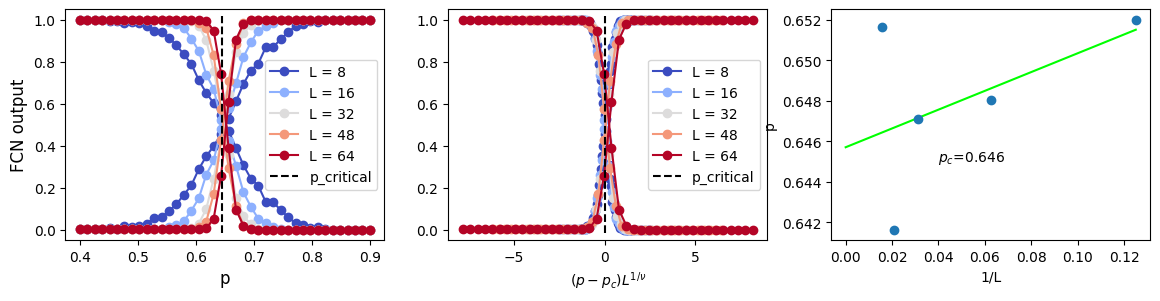

In [13]:
plot_figure(Ls, percolation_probabilities_FCN, modeltype = "FCN")

(<Figure size 1400x300 with 3 Axes>,
 array([<Axes: xlabel='p', ylabel='CNN output'>,
        <Axes: xlabel='$(p-p_c)L^{1/\\nu}$'>,
        <Axes: xlabel='1/L', ylabel='p'>], dtype=object))

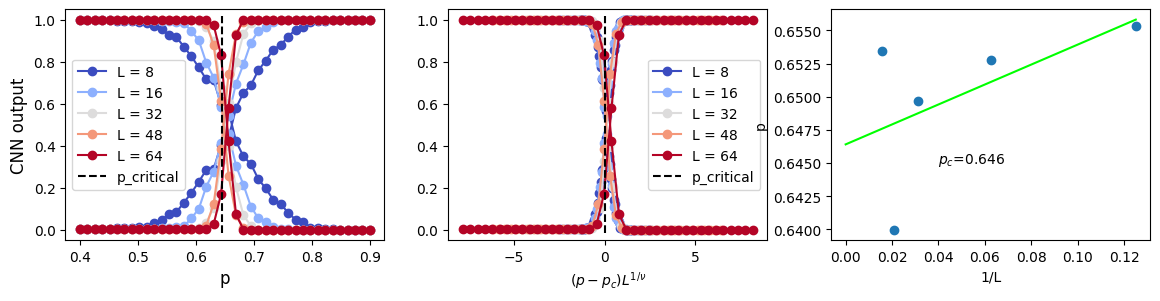

In [14]:
plot_figure(Ls, percolation_probabilities_CNN, modeltype = "CNN")

# Unsupervised learning approach

An interesting result of the paper is that an autoencoder trained on a generated DP dataset can be used to infer the critical probability $p_c$.

We train a simple autoencoder with only one hidden neuron. Ideally, the autoencoder should learn to use that neuron to "classify" the input configuration as percolating or non-percolating.

In [15]:
L, T = 80, 120
p_min, p_max = .1, .9
p_critical = .6447

ps = np.linspace(p_min, p_max, 40) # used probabilities
n_samples = 1000 # number of samples per probability value

#### Generate data - only run the first time!

In [ ]:
"""
Generate 1000 configurations for each value of p
"""

data = torch.zeros((n_samples*len(ps), T, L)).to(device) # shape has to be *len(ps)
for i,p in enumerate(ps):
  for j in range(n_samples):
    data[i*n_samples + j, :, :] = simulate_DP(L, T, p, device, full = True)

file_name = "/content/drive/MyDrive/dataset_autoencoder"

In [ ]:
torch.save(data, file_name)

## Train autoencoder

In [16]:
# Load data
data = torch.load("/content/drive/MyDrive/dataset_autoencoder",
                  map_location=torch.device(device))

data = torch.unsqueeze(data, 1)

# Split into training and test (80%, 20%)
index_train = [i*n_samples + j for i in range(len(ps)) for j in range(80*n_samples // 100)]
index_test = [i*n_samples + 80*n_samples // 100 + j for i in range(len(ps)) for j in range(n_samples * 20 // 100)]
data_train, data_test = data[index_train, :], data[index_test, :]

# Create datasets and dataloaders
batch_size = 32
training_set, test_set = TensorDataset(data_train), TensorDataset(data_test)
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [17]:
""" Autoencoder architecture:
 - Encoder: two convolutional layers with two MaxPooling layers
 - Hidden: one hidden neuron
 - Decoder: two convolutional layers, two upsampling layers
"""

class Autoencoder(nn.Module):
  def __init__(self, L, T):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Conv2d(8, 16, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.projection = nn.Linear(L*T, 1)
    self.projection2 = nn.Linear(1, L*T)

    self.decoder = nn.Sequential(nn.Conv2d(16, 8, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor = 2),
                                 nn.Conv2d(8, 1, kernel_size = 3, padding = 'same', padding_mode = 'zeros'),
                                 nn.ReLU(),
                                 nn.Upsample(scale_factor = 2))

  def forward(self, data):
    encoded = self.encoder(data)
    encoded = torch.flatten(encoded, start_dim = 1, end_dim = -1)

    hidden = torch.sigmoid(self.projection(encoded))

    decoded = torch.reshape(self.projection2(hidden), (-1, 16, T//4, L//4))
    decoded = self.decoder(decoded)

    return decoded, hidden

  def generate_sample(self, h):
    hidden = h
    decoded = torch.reshape(self.projection2(hidden), (-1, 16, T//4, L//4))
    decoded = self.decoder(decoded)

    return decoded


In [18]:
# Train the autoencoder!
autoencoder = Autoencoder(L, T).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=0.01)

n_epochs = 4

for epoch in range(n_epochs):
  ## Training loss
  autoencoder.train()
  train_loss = 0.0
  for inputs in train_loader:
    optimizer.zero_grad()
    outputs, _ = autoencoder(inputs[0])
    loss = criterion(outputs, inputs[0])
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * inputs[0].size(0)
  train_loss /= len(train_loader.dataset)

  ## Loss on the test set
  test_loss = 0.0
  autoencoder.eval()
  with torch.no_grad():
      for inputs in test_loader:
          outputs, _ = autoencoder(inputs[0])
          loss = criterion(outputs, inputs[0])
          test_loss += loss.item() * inputs[0].size(0)

  test_loss /= len(test_loader.dataset)
  print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {test_loss:.4f}')



Epoch [1/4], Training Loss: 0.0948, Validation Loss: 0.0715
Epoch [2/4], Training Loss: 0.0656, Validation Loss: 0.0646
Epoch [3/4], Training Loss: 0.0645, Validation Loss: 0.0647
Epoch [4/4], Training Loss: 0.0645, Validation Loss: 0.0652


In [19]:
# Compute average value of hidden neuron on test set
hiddens = {}
autoencoder.eval()

for i,p in enumerate(ps):
  values = []
  for j in range(n_samples // 5):
    _, hidden = autoencoder(torch.unsqueeze(data_test[i*(n_samples//5) + j , :], 0))
    values.append(hidden.item())
  hiddens[p] = np.mean(np.array(values))

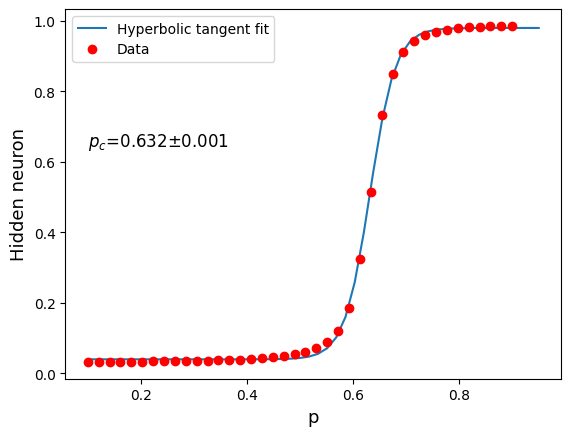

In [20]:
xs, ys = list(hiddens.keys()), list(hiddens.values())

def tanh(x, a, b, pc, c):
  return c + a*np.tanh(b*(x-pc))

params, covs = curve_fit(tanh, xs, ys)

plt.plot(np.linspace(0.1, 0.95), tanh(np.linspace(0.1,0.95), *params), label = "Hyperbolic tangent fit")
plt.plot(xs, ys, "o", c = "red", label = "Data")
plt.text(.1, .645, r"$p_c$" + f'={params[2]:0.3f}' + r'$\pm$' + f'{np.sqrt(covs[2,2]):0.3f}',
         color = "black", fontsize = 12)
plt.xlabel("p", fontsize = 13)
plt.ylabel("Hidden neuron", fontsize = 13)
plt.legend()

The estimate of $p_c$ found through unsupervised learning is $p_c = 0.643\pm0.001$, which is compatible with the value given by the literature of 0.6447.

As a nice experiment, we can look at some samples generated by the autoencoder for random values of the hidden variable.

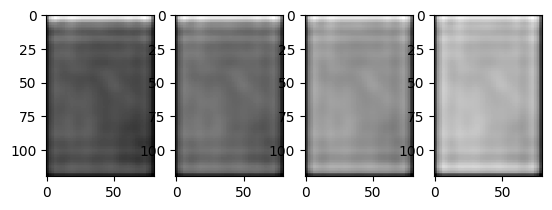

In [ ]:
hs = [.4, .5, .7, .9]
fig, ax = plt.subplots(1, 4)

for i,h in enumerate(hs):
  sample = autoencoder.generate_sample(torch.unsqueeze(torch.tensor(h).to(device), 0))
  ax[i].imshow(torch.permute(torch.squeeze(sample.detach().cpu(), 0), (1,2,0)), cmap = 'gray')

